In [1]:
import glob
import pandas as pd
import numpy as np
import os
import scipy
import random
import librosa
import librosa.display
import random
import matplotlib.pyplot as plt
from IPython.display import Audio


In [2]:
VALIDATION_SET_SIZE = 0.2

def bool_random(prob):
    r = random.random()
    if r <= prob:
        return True
    else:
        return False


def read_voice_files(dir_path):
    filenames = glob.glob(dir_path + "*.wav")
    name_to_files = dict()
    for i in range(len(filenames)):
        filepath = filenames[i]
        person_name = filepath.split("\\")[-1].split(".")[0].split("-")[:2]
        person_name = person_name[0] + "-" + person_name[1]
        if person_name in name_to_files.keys():
            name_to_files[person_name].append(filepath)
        else:
            name_to_files[person_name] = [filepath]
    return name_to_files


def train_validation_split(validation_size, name_to_files):
    X_t = dict()
    X_v = dict()
    for k, v in name_to_files.items():
        for f in v:
            belongs_to_validation = bool_random(validation_size)
            if belongs_to_validation:
                if k in X_v:
                    X_v[k].append(f)
                else:
                    X_v[k] = [f]
            else:
                if k in X_t:
                    X_t[k].append(f)
                else:
                    X_t[k] = [f]

    return X_t, X_v

# Given folder containing audio files (*.wav)
# returns split filenames into training and validation sets
def get_data(audio_folder):
    files_dict = read_voice_files(audio_folder)
    return train_validation_split(VALIDATION_SET_SIZE, files_dict)

In [3]:
# Returns list of lists: [correct number, student's name, matrix of a spectogram]
def process_data(X_train):
    ls = parse_features(X_train)
    for features in ls:
        features[2] = create_spectogram(features[2])
    return ls


# Creates matrix of a spectogram 
def create_spectogram(wav_file):
    signal, sampling_rate = librosa.load(wav_file)
    matrix = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)

    # matrix = mfcc(signal, sampling_rate, nfft=551)          #WE MIGHT USE THIS OR ANOTHER ALGORITHM TO CREATE MATRIX (python_speech_features library)
    # print(wav_file)
    # librosa.display.specshow(matrix, y_axis='linear')    #TO PLOT CREATED SPECTOGRAM IMAGE
    # plt.show()
    
    return matrix


# Returns list of lists: [correct number, student's name, path to audio file]
def parse_features(X_train) :
    ls = []
    for wav_name, wav_files in X_train.items():
        name = wav_name[wav_name.index('/') + 1:]
        
        for audio_file in wav_files:
            number = int(''.join(ch for ch in list(audio_file) if ch.isdigit()))
            ls.append([name, number, audio_file])
    
    return ls

In [4]:
def get_pure_spectogram(train_input):
    pure_spectograms = []
    # Extracting spectograms for every entry
    for entity in train_input:
        # Every spectogram should have third dimension the same
        if entity[2].shape[1] == 31:
            pure_spectograms.append(entity[2].copy())
        # Otherwise fill dimension with 0s
        # else:
        #     remaining = 31 - entity[2].shape[1]
        #     arr = np.append( entity[2].copy(), [0 for _ in range(remaining)])
        #     print(arr.shape)
        #     pure_spectograms.append( np.append( entity[2].copy(), [0 for _ in range(remaining)]))
    # Create and return numpy 3D matrix
    return np.array(pure_spectograms, copy=True)


In [5]:
X_train, X_validation = get_data("data_cut/")

In [7]:
random_wav = random.choice(X_train[random.choice(list(X_train.keys()))])
random_wav

'data_cut/lasha-kiti-2b.wav'

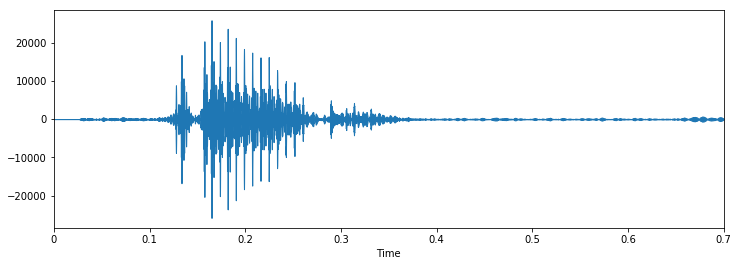

In [9]:
sample_rate, samples = scipy.io.wavfile.read(random_wav)
plt.figure(figsize=(12, 4))
librosa.display.waveplot(samples.astype('float'), sr=sample_rate)
plt.show()

In [10]:
Audio(random_wav, rate=sample_rate)

In [12]:
# Adding noise to audio

# y_noise = samples.copy()
# noise_amp = 0.005*np.random.uniform()*np.amax(y_noise)
# y_noise = y_noise.astype('float64') + noise_amp * np.random.normal(size=y_noise.shape[0])
# Audio(y_noise, rate=sample_rate)

In [13]:
sampling=samples[(samples > 200) | (samples < -200)]
shifted_silent =sampling.tolist()+np.zeros((samples.shape[0]-sampling.shape[0])).tolist()
Audio(shifted_silent, rate=sample_rate)


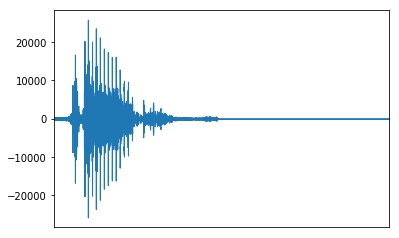

In [14]:
librosa.display.waveplot(np.array(shifted_silent).astype('float'), sr=sample_rate,x_axis=None)


In [16]:
X_train = process_data(X_train)
X_validation = process_data(X_validation)

In [17]:
df = pd.DataFrame.from_records(X_train)

In [21]:
y_train = np.expand_dims([e[1] for e in X_train], -1)
y_validation = np.expand_dims([e[1] for e in X_validation], -1)

In [20]:
X_train_pure = get_pure_spectogram(X_train)
X_validation_pure = get_pure_spectogram(X_validation)
print(X_validation_pure.shape)
print(X_train_pure.shape)

(138, 1025, 31)
(529, 1025, 31)
